In [2]:
import os
import random
import _pickle as pickle
import numpy as np
import matplotlib.pyplot
from matplotlib.pyplot import imshow
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from sklearn.decomposition import PCA
from scipy.spatial import distance
from tqdm import tqdm

In [17]:
# pip install falconn
# import falconn

ModuleNotFoundError: No module named 'falconn'

In [3]:
# Call the base imagenet model with VGG16
model = keras.applications.VGG16(weights='imagenet', include_top=True)
model.summary()

553467904/553467096 [==============================] - 18s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

In [4]:
# get_image will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

### Test out a sample predicted image

40960/35363 [==================================] - 0s 1us/step
predicted cheeseburger with probability 0.835
predicted bagel with probability 0.124
predicted meat_loaf with probability 0.014
predicted plate with probability 0.008
predicted bakery with probability 0.006


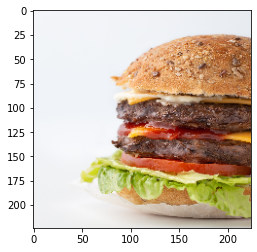

In [9]:
img, x = get_image("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\data\\food_image_test\\burger.jpg")
predictions = model.predict(x)
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

## Doing this with last-to-second layer

In [10]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

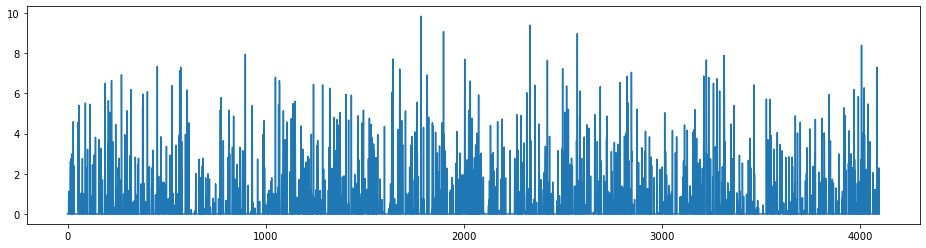

In [12]:
img, x = get_image("C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\data\\food_image_test\\burger.jpg")
feat = feat_extractor.predict(x)

matplotlib.pyplot.figure(figsize=(16,4))
matplotlib.pyplot.plot(feat[0])
matplotlib.pyplot.show()

In [43]:
images_path = 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\data\\food_image_test\\'
max_num_images = 6

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 6 images to analyze


In [44]:
images[:10]

['C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\food_image_test\\burger\\burger-1.jpg',
 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\food_image_test\\burger\\burger-2.jpg',
 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\food_image_test\\cookie\\cookie-1.jpg',
 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\food_image_test\\cookie\\cookie-2.jpg',
 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\food_image_test\\salad\\salad-1.jpg',
 'C:\\Users\\Nilay\\Documents\\GitHub\\OMCS_CS7643_DL\\data\\food_image_test\\salad\\salad-2.jpg']

In [45]:
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

100%|██████████| 6/6 [00:01<00:00,  3.28it/s]


## PCA

In [46]:
features = np.array(features)
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

In [47]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

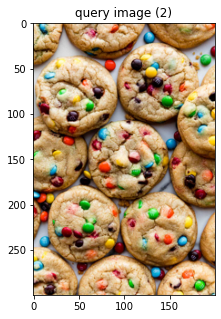

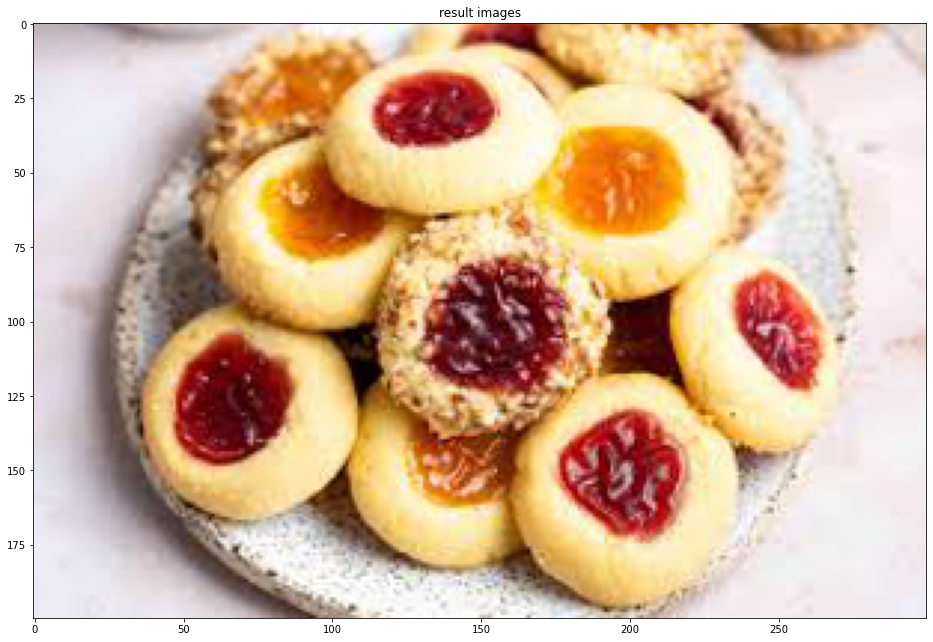

In [73]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx, 1)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
matplotlib.pyplot.figure(figsize = (5,5))
imshow(query_image)
matplotlib.pyplot.title("query image (%d)" % query_image_idx)

# display the resulting images
matplotlib.pyplot.figure(figsize = (16,12))
imshow(results_image)
matplotlib.pyplot.title("result images")

In [74]:
images[idx_closest[0]].split("\\")[8]

'cookie'

## t-SNE Visualizing

In [55]:
num_images_to_plot = 6

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [56]:
import json
import matplotlib.pyplot
from PIL import Image
from sklearn.manifold import TSNE

X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

E:\anaconda\envs\food\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


[t-SNE] Computing 5 nearest neighbors...
[t-SNE] Indexed 6 samples in 0.000s...
[t-SNE] Computed neighbors for 6 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 6 / 6
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Computed conditional probabilities in 0.001s
[t-SNE] Iteration 50: error = 40.0335083, gradient norm = 0.7012744 (50 iterations in 0.029s)
[t-SNE] Iteration 100: error = 57.5402107, gradient norm = 0.2797951 (50 iterations in 0.012s)
[t-SNE] Iteration 150: error = 35.8210945, gradient norm = 0.1955860 (50 iterations in 0.012s)
[t-SNE] Iteration 200: error = 50.3999825, gradient norm = 0.1949998 (50 iterations in 0.010s)
[t-SNE] Iteration 250: error = 34.2546158, gradient norm = 0.2895812 (50 iterations in 0.014s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 34.254616
[t-SNE] Iteration 300: error = 0.1580946, gradient norm = 0.0001286 (50 iterations in 0.011s)
[t-SNE] Iteration 350: error = 0.1579955, gradient norm = 0.000

In [57]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

0it [00:00, ?it/s]C:\Users\Nilay\AppData\Local\Temp\ipykernel_4920\3253945560.py:9: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
6it [00:01,  5.03it/s]


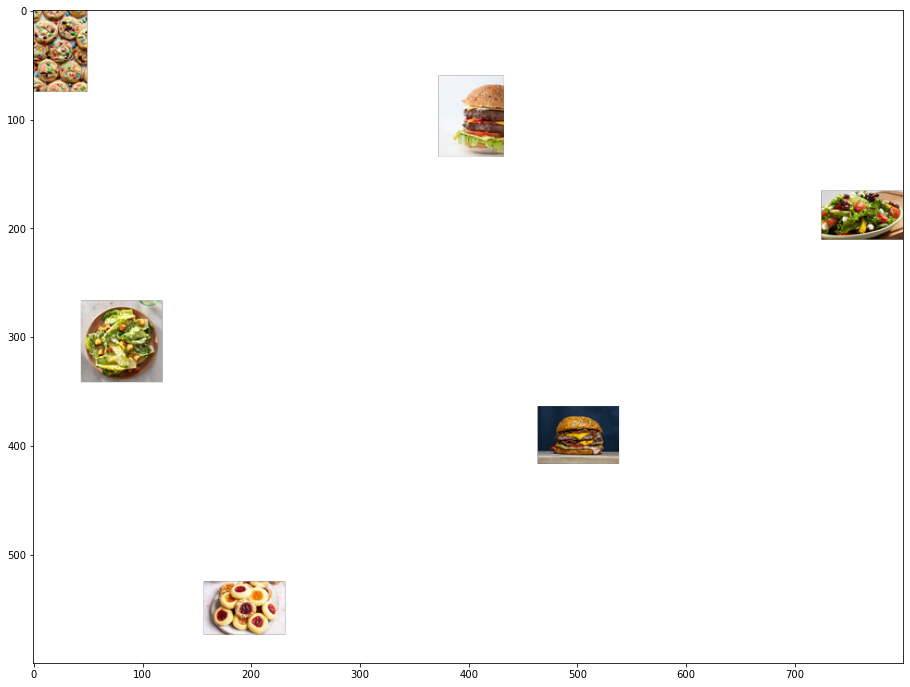

In [60]:
width = 800
height = 600
max_dim = 75

full_image = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)
full_image.save("/data/6-pics-cloud.png")